# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from ResNet import ResnetBuilder # ResNet.py
import json
import itertools
import gc
import glob
from IPython.display import clear_output

# 2. Data Processing

## 2.1 Load Data

In [2]:
# 元データはCSV．各列がピクセルの位置を示しており各行が個々のデータを表す．
train = pd.read_csv("./data/train.csv") # trainのみ1列目にラベル(0-9)が与えられている
test = pd.read_csv("./data/test.csv")

# 画像サイズ
img_size_x = 28
img_size_y = 28
channels = 1

# trainラベル
label_num = train.label # 0-9
label = pd.get_dummies(label_num).values # one-hot encoding
class_names = np.unique(label_num).astype("str") # クラス名 "0"-"9"
n_classes = len(np.unique(label_num)) # クラス数　=　10

# trainからラベル列を削除
train = train.drop(labels = ["label"], axis = 1) 

## 2.2 Preprocess

In [ ]:
# 平均０，分散１となるように各データを正規化
train = scale(train, axis=1)
test = scale(test, axis=1)

# 元データを入力形状(データ数*28*28*1)に変換
train = train.reshape(-1,28,28,1).astype('float32')
test = test.reshape(-1,28,28,1).astype('float32')

## 2.3 Show Image Sample

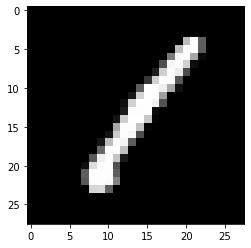

In [4]:
plt.figure()
plt.imshow(train[0,:,:,0], cmap='gray') #,cmap='gray',origin='lower'
plt.show()

# 3. Model Summary

## 3.1 Structure

In [6]:
inputShape=(img_size_x, img_size_y, channels)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50モデル
ResNetModel.summary()
clear_session()
del ResNetModel
gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

102835

## 3.2 Result Setting

In [6]:
# modelのバージョン毎に結果保存用のフォルダを作成
model_name = "ResNet50_epoch10" # 設定に変更があった場合ここだけ変更
csv_dir = "./Result/"+model_name 
conf_dir = csv_dir+"/CM_result" # 混合行列画像保存用のサブフォルダ
#model_dir = csv_dir+"/model_dir"

# 新規にフォルダを作成する関数．同名のフォルダがすでに存在する場合は削除して作り直す
def my_makedirs(path):
    if not os.path.isdir(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)
        os.makedirs(path)
        
# 結果保存用フォルダの作成
my_makedirs(csv_dir)
my_makedirs(conf_dir)
#my_makedirs(model_dir)

# 4. Evaluate Model

## 4.1 Training Setting

In [7]:
# 学習の設定
inputShape=(img_size_x, img_size_y, channels)
batch_size = 512 # 32, 64, 128, 256, 512(first), 1024, 2048など調整
n_epoch = 10 # エポック数
learning_rate = 0.001 #0.003
early_stopping_patience = 300 # 性能向上がない場合，学習を早期終了するエポック数
sp = 10 # 交差検証の分割数

# 評価指標の設定(accuracy, 各クラスのprecision, recall, fscoreとそれらの平均)
predict = np.empty([len(label), n_classes])
predict_label = np.empty([len(label), n_classes])
acc_list = np.empty([sp,1])
precision_list = np.empty([sp, n_classes])
recall_list = np.empty([sp, n_classes])
fscore_list = np.empty([sp, n_classes])
avg_precision = np.empty([sp,1])
avg_recall = np.empty([sp,1])
avg_fscore = np.empty([sp,1])

## 4.2 Training and Validation (10-fold cross validation)

### 4.2.1 Each fold iteration

Iteration No. 1

Train on 37794 samples, validate on 4206 samples
Epoch 1/10
37376/37794 [============================>.] - ETA: 0s - loss: 4.8784 - acc: 0.9438
Epoch 00001: val_loss improved from inf to 9.67242, saving model to img_classifier_model_1_ResNet50_epoch10.h5
37794/37794 [==============================] - 28s 733us/sample - loss: 4.8712 - acc: 0.9442 - val_loss: 9.6724 - val_acc: 0.4296
Epoch 2/10
37376/37794 [============================>.] - ETA: 0s - loss: 3.8143 - acc: 0.9932
Epoch 00002: val_loss improved from 9.67242 to 3.57824, saving model to img_classifier_model_1_ResNet50_epoch10.h5
37794/37794 [==============================] - 14s 371us/sample - loss: 3.8108 - acc: 0.9931 - val_loss: 3.5782 - val_acc: 0.9655
Epoch 3/10
37376/37794 [============================>.] - ETA: 0s - loss: 3.2157 - acc: 0.9989
Epoch 00003: val_loss improved from 3.57824 to 3.03183, saving model to img_classifier_model_1_ResNet50_epoch10.h5
37794/37794 [==============================] - 1

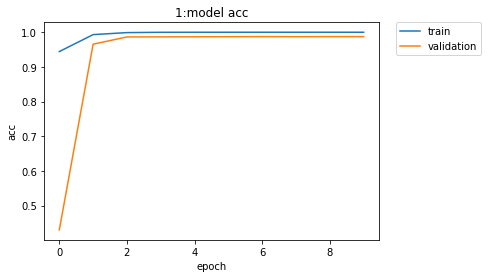

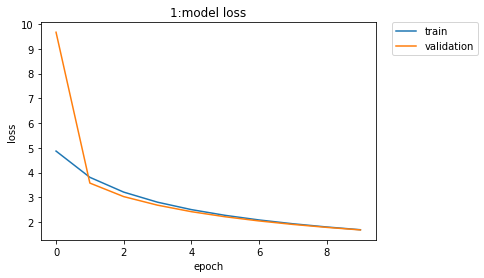

Done compiling best model.


1. Accuracy on validation data: 0.987399
Classification Report
              precision    recall  f1-score   support

           0    0.99041   0.99758   0.99398       414
           1    0.99574   0.99574   0.99574       469
           2    0.98798   0.98325   0.98561       418
           3    0.99078   0.98624   0.98851       436
           4    0.98526   0.98284   0.98405       408
           5    0.98939   0.98158   0.98547       380
           6    0.98798   0.99275   0.99036       414
           7    0.98202   0.99093   0.98646       441
           8    0.99259   0.98771   0.99015       407
           9    0.97143   0.97375   0.97259       419

   micro avg    0.98740   0.98740   0.98740      4206
   macro avg    0.98736   0.98724   0.98729      4206
weighted avg    0.98741   0.98740   0.98740      4206
 samples avg    0.98740   0.98740   0.98740      4206





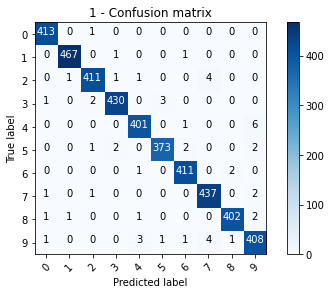

Iteration No. 2

Train on 37796 samples, validate on 4204 samples
Epoch 1/10
37376/37796 [============================>.] - ETA: 0s - loss: 4.8942 - acc: 0.9425
Epoch 00001: val_loss improved from inf to 6.63789, saving model to img_classifier_model_2_ResNet50_epoch10.h5
37796/37796 [==============================] - 26s 681us/sample - loss: 4.8870 - acc: 0.9429 - val_loss: 6.6379 - val_acc: 0.6974
Epoch 2/10
37376/37796 [============================>.] - ETA: 0s - loss: 3.8472 - acc: 0.9922
Epoch 00002: val_loss improved from 6.63789 to 3.60657, saving model to img_classifier_model_2_ResNet50_epoch10.h5
37796/37796 [==============================] - 14s 379us/sample - loss: 3.8435 - acc: 0.9922 - val_loss: 3.6066 - val_acc: 0.9665
Epoch 3/10
37376/37796 [============================>.] - ETA: 0s - loss: 3.2535 - acc: 0.9984- ETA: 2s - loss: 3.2902 -
Epoch 00003: val_loss improved from 3.60657 to 3.08955, saving model to img_classifier_model_2_ResNet50_epoch10.h5
37796/37796 [=========

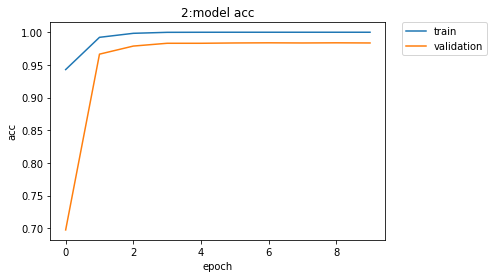

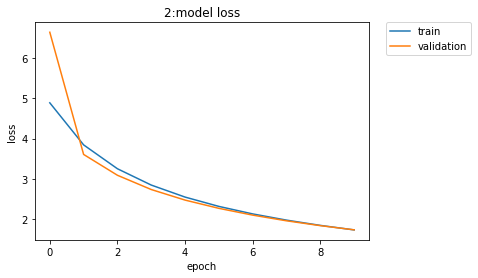

Done compiling best model.


2. Accuracy on validation data: 0.983587
Classification Report
              precision    recall  f1-score   support

           0    0.98100   0.99758   0.98922       414
           1    1.00000   0.98721   0.99356       469
           2    0.97613   0.97847   0.97730       418
           3    0.97931   0.97931   0.97931       435
           4    0.99017   0.98775   0.98896       408
           5    0.97878   0.97105   0.97490       380
           6    0.99265   0.97826   0.98540       414
           7    0.98864   0.98864   0.98864       440
           8    0.97101   0.98771   0.97929       407
           9    0.97619   0.97852   0.97735       419

   micro avg    0.98359   0.98359   0.98359      4204
   macro avg    0.98339   0.98345   0.98339      4204
weighted avg    0.98365   0.98359   0.98359      4204
 samples avg    0.98359   0.98359   0.98359      4204





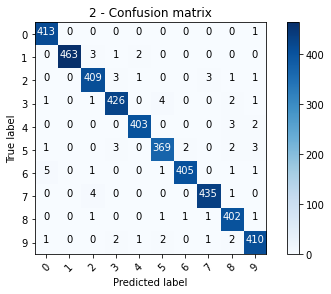

Iteration No. 3

Train on 37798 samples, validate on 4202 samples
Epoch 1/10
37376/37798 [============================>.] - ETA: 0s - loss: 4.8961 - acc: 0.9437
Epoch 00001: val_loss improved from inf to 9.04692, saving model to img_classifier_model_3_ResNet50_epoch10.h5
37798/37798 [==============================] - 25s 658us/sample - loss: 4.8888 - acc: 0.9442 - val_loss: 9.0469 - val_acc: 0.4591
Epoch 2/10
37376/37798 [============================>.] - ETA: 0s - loss: 3.8539 - acc: 0.9921
Epoch 00002: val_loss improved from 9.04692 to 3.73801, saving model to img_classifier_model_3_ResNet50_epoch10.h5
37798/37798 [==============================] - 14s 363us/sample - loss: 3.8503 - acc: 0.9921 - val_loss: 3.7380 - val_acc: 0.9319
Epoch 3/10
37376/37798 [============================>.] - ETA: 0s - loss: 3.2603 - acc: 0.9980
Epoch 00003: val_loss improved from 3.73801 to 3.07323, saving model to img_classifier_model_3_ResNet50_epoch10.h5
37798/37798 [==============================] - 1

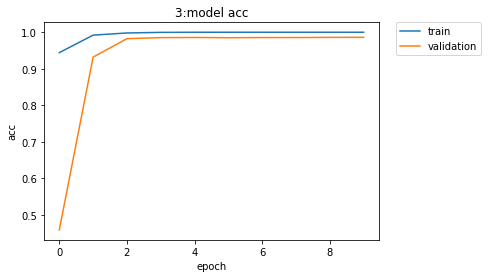

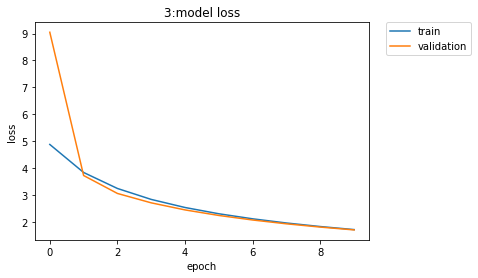

Done compiling best model.


3. Accuracy on validation data: 0.986197
Classification Report
              precision    recall  f1-score   support

           0    0.99274   0.99274   0.99274       413
           1    0.99149   0.99360   0.99255       469
           2    0.98801   0.98565   0.98683       418
           3    0.97738   0.99310   0.98518       435
           4    0.98775   0.99017   0.98896       407
           5    1.00000   0.96579   0.98260       380
           6    0.99038   0.99517   0.99277       414
           7    0.99539   0.98182   0.98856       440
           8    0.96403   0.98771   0.97573       407
           9    0.97608   0.97375   0.97491       419

   micro avg    0.98620   0.98620   0.98620      4202
   macro avg    0.98632   0.98595   0.98608      4202
weighted avg    0.98631   0.98620   0.98620      4202
 samples avg    0.98620   0.98620   0.98620      4202





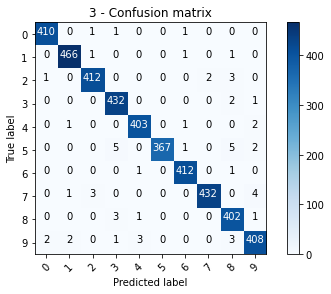

Iteration No. 4

Train on 37799 samples, validate on 4201 samples
Epoch 1/10
37376/37799 [============================>.] - ETA: 0s - loss: 4.8902 - acc: 0.9431
Epoch 00001: val_loss improved from inf to 9.12369, saving model to img_classifier_model_4_ResNet50_epoch10.h5
37799/37799 [==============================] - 26s 677us/sample - loss: 4.8834 - acc: 0.9435 - val_loss: 9.1237 - val_acc: 0.4808
Epoch 2/10
37376/37799 [============================>.] - ETA: 0s - loss: 3.8618 - acc: 0.9915
Epoch 00002: val_loss improved from 9.12369 to 3.61926, saving model to img_classifier_model_4_ResNet50_epoch10.h5
37799/37799 [==============================] - 14s 377us/sample - loss: 3.8581 - acc: 0.9915 - val_loss: 3.6193 - val_acc: 0.9681
Epoch 3/10
37376/37799 [============================>.] - ETA: 0s - loss: 3.2754 - acc: 0.9983
Epoch 00003: val_loss improved from 3.61926 to 3.10299, saving model to img_classifier_model_4_ResNet50_epoch10.h5
37799/37799 [==============================] - 1

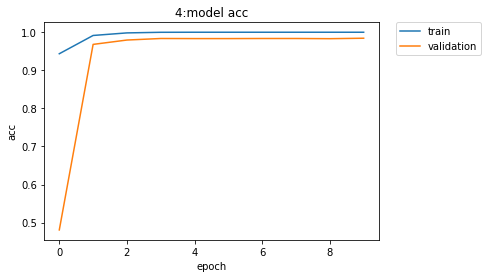

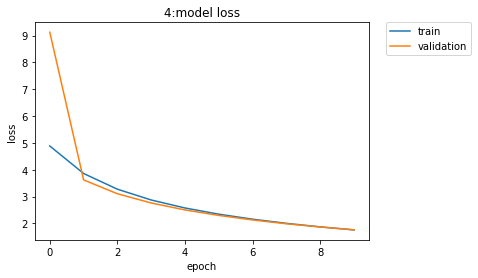

Done compiling best model.


4. Accuracy on validation data: 0.984289
Classification Report
              precision    recall  f1-score   support

           0    0.98558   0.99274   0.98914       413
           1    0.99570   0.98721   0.99143       469
           2    0.98575   0.99282   0.98927       418
           3    0.97511   0.99080   0.98290       435
           4    0.98507   0.97297   0.97899       407
           5    0.99459   0.96842   0.98133       380
           6    0.98091   0.99275   0.98679       414
           7    0.98186   0.98409   0.98297       440
           8    0.97810   0.99015   0.98409       406
           9    0.98068   0.96897   0.97479       419

   micro avg    0.98429   0.98429   0.98429      4201
   macro avg    0.98434   0.98409   0.98417      4201
weighted avg    0.98435   0.98429   0.98428      4201
 samples avg    0.98429   0.98429   0.98429      4201





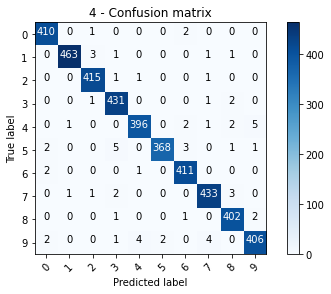

Iteration No. 5

Train on 37800 samples, validate on 4200 samples
Epoch 1/10
37376/37800 [============================>.] - ETA: 0s - loss: 4.8684 - acc: 0.9448
Epoch 00001: val_loss improved from inf to 7.47062, saving model to img_classifier_model_5_ResNet50_epoch10.h5
37800/37800 [==============================] - 25s 666us/sample - loss: 4.8611 - acc: 0.9453 - val_loss: 7.4706 - val_acc: 0.6060
Epoch 2/10
37376/37800 [============================>.] - ETA: 0s - loss: 3.8028 - acc: 0.9923
Epoch 00002: val_loss improved from 7.47062 to 3.55418, saving model to img_classifier_model_5_ResNet50_epoch10.h5
37800/37800 [==============================] - 14s 367us/sample - loss: 3.7994 - acc: 0.9923 - val_loss: 3.5542 - val_acc: 0.9686
Epoch 3/10
37376/37800 [============================>.] - ETA: 0s - loss: 3.2044 - acc: 0.9982
Epoch 00003: val_loss improved from 3.55418 to 3.03377, saving model to img_classifier_model_5_ResNet50_epoch10.h5
37800/37800 [==============================] - 1

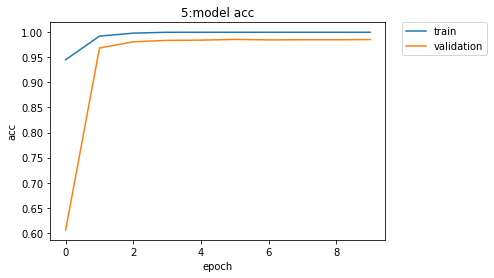

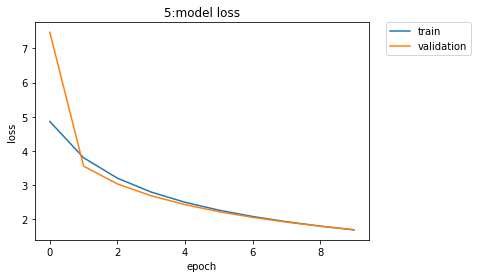

Done compiling best model.


5. Accuracy on validation data: 0.985476
Classification Report
              precision    recall  f1-score   support

           0    0.99513   0.99031   0.99272       413
           1    0.99352   0.98291   0.98818       468
           2    0.97872   0.99043   0.98454       418
           3    0.98848   0.98621   0.98734       435
           4    0.99010   0.98280   0.98644       407
           5    0.98942   0.98421   0.98681       380
           6    0.98783   0.98068   0.98424       414
           7    0.98420   0.99091   0.98754       440
           8    0.96618   0.98522   0.97561       406
           9    0.98091   0.98091   0.98091       419

   micro avg    0.98548   0.98548   0.98548      4200
   macro avg    0.98545   0.98546   0.98543      4200
weighted avg    0.98554   0.98548   0.98549      4200
 samples avg    0.98548   0.98548   0.98548      4200





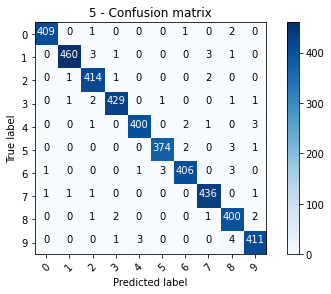

Iteration No. 6

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37376/37801 [============================>.] - ETA: 0s - loss: 4.9008 - acc: 0.9428- ETA: 4s - loss: 5.0236 - acc: 0.93 - ETA: 3s - loss: 5.0053 -
Epoch 00001: val_loss improved from inf to 6.05235, saving model to img_classifier_model_6_ResNet50_epoch10.h5
37801/37801 [==============================] - 26s 677us/sample - loss: 4.8938 - acc: 0.9432 - val_loss: 6.0524 - val_acc: 0.6692
Epoch 2/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.8774 - acc: 0.9914
Epoch 00002: val_loss improved from 6.05235 to 3.59617, saving model to img_classifier_model_6_ResNet50_epoch10.h5
37801/37801 [==============================] - 14s 380us/sample - loss: 3.8737 - acc: 0.9915 - val_loss: 3.5962 - val_acc: 0.9779
Epoch 3/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.2928 - acc: 0.9980
Epoch 00003: val_loss improved from 3.59617 to 3.11618, saving model to img_classifier_model_6_ResNe

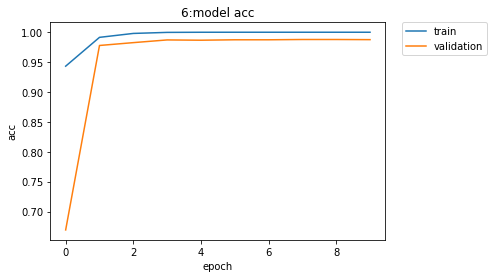

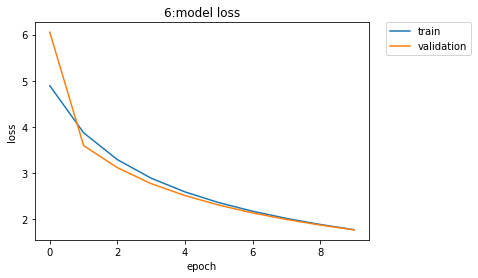

Done compiling best model.


6. Accuracy on validation data: 0.987616
Classification Report
              precision    recall  f1-score   support

           0    0.98561   0.99516   0.99036       413
           1    0.99147   0.99359   0.99253       468
           2    0.98561   0.98325   0.98443       418
           3    0.99076   0.98621   0.98848       435
           4    0.99259   0.98771   0.99015       407
           5    0.99467   0.98417   0.98939       379
           6    0.99758   0.99517   0.99637       414
           7    0.98198   0.99091   0.98643       440
           8    0.96845   0.98276   0.97555       406
           9    0.98792   0.97613   0.98199       419

   micro avg    0.98762   0.98762   0.98762      4199
   macro avg    0.98766   0.98751   0.98757      4199
weighted avg    0.98766   0.98762   0.98762      4199
 samples avg    0.98762   0.98762   0.98762      4199





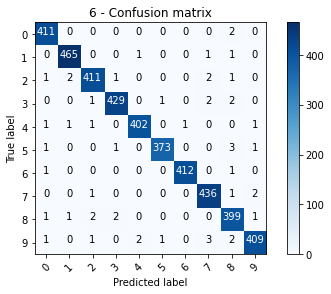

Iteration No. 7

Train on 37801 samples, validate on 4199 samples
Epoch 1/10
37376/37801 [============================>.] - ETA: 0s - loss: 4.9046 - acc: 0.9420
Epoch 00001: val_loss improved from inf to 5.27882, saving model to img_classifier_model_7_ResNet50_epoch10.h5
37801/37801 [==============================] - 22s 594us/sample - loss: 4.8974 - acc: 0.9424 - val_loss: 5.2788 - val_acc: 0.7992
Epoch 2/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.8653 - acc: 0.9907
Epoch 00002: val_loss improved from 5.27882 to 3.59378, saving model to img_classifier_model_7_ResNet50_epoch10.h5
37801/37801 [==============================] - 14s 366us/sample - loss: 3.8615 - acc: 0.9907 - val_loss: 3.5938 - val_acc: 0.9726
Epoch 3/10
37376/37801 [============================>.] - ETA: 0s - loss: 3.2737 - acc: 0.9979
Epoch 00003: val_loss improved from 3.59378 to 3.09155, saving model to img_classifier_model_7_ResNet50_epoch10.h5
37801/37801 [==============================] - 1

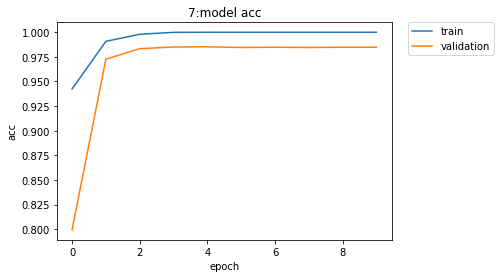

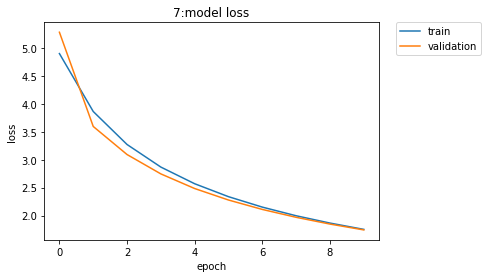

Done compiling best model.


7. Accuracy on validation data: 0.984758
Classification Report
              precision    recall  f1-score   support

           0    0.98091   0.99516   0.98798       413
           1    0.99360   0.99573   0.99466       468
           2    0.98305   0.97129   0.97714       418
           3    0.99531   0.97471   0.98490       435
           4    0.98522   0.98280   0.98401       407
           5    0.99202   0.98417   0.98808       379
           6    0.99510   0.98068   0.98783       414
           7    0.98194   0.98864   0.98528       440
           8    0.96420   0.99507   0.97939       406
           9    0.97619   0.97852   0.97735       419

   micro avg    0.98476   0.98476   0.98476      4199
   macro avg    0.98475   0.98468   0.98466      4199
weighted avg    0.98487   0.98476   0.98476      4199
 samples avg    0.98476   0.98476   0.98476      4199





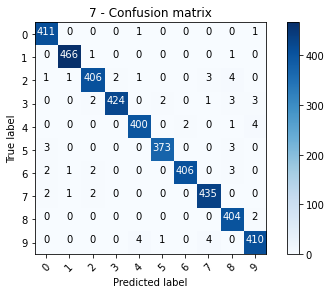

Iteration No. 8

Train on 37803 samples, validate on 4197 samples
Epoch 1/10
37376/37803 [============================>.] - ETA: 0s - loss: 4.8920 - acc: 0.9426
Epoch 00001: val_loss improved from inf to 10.73441, saving model to img_classifier_model_8_ResNet50_epoch10.h5
37803/37803 [==============================] - 25s 669us/sample - loss: 4.8847 - acc: 0.9432 - val_loss: 10.7344 - val_acc: 0.4803
Epoch 2/10
37376/37803 [============================>.] - ETA: 0s - loss: 3.8488 - acc: 0.9922
Epoch 00002: val_loss improved from 10.73441 to 3.67945, saving model to img_classifier_model_8_ResNet50_epoch10.h5
37803/37803 [==============================] - 14s 378us/sample - loss: 3.8450 - acc: 0.9923 - val_loss: 3.6794 - val_acc: 0.9459
Epoch 3/10
37376/37803 [============================>.] - ETA: 0s - loss: 3.2549 - acc: 0.9986
Epoch 00003: val_loss improved from 3.67945 to 3.06659, saving model to img_classifier_model_8_ResNet50_epoch10.h5
37803/37803 [==============================] 

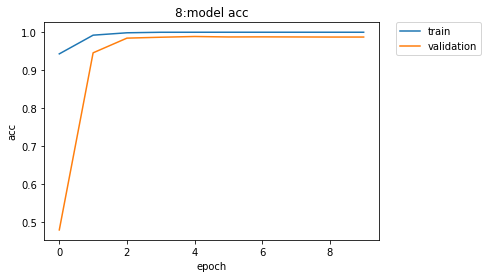

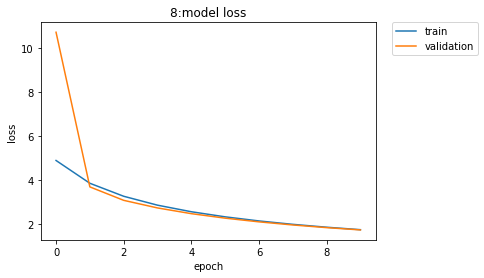

Done compiling best model.


8. Accuracy on validation data: 0.987372
Classification Report
              precision    recall  f1-score   support

           0    0.98086   0.99274   0.98676       413
           1    0.98734   1.00000   0.99363       468
           2    0.99279   0.99041   0.99160       417
           3    1.00000   0.97931   0.98955       435
           4    0.98765   0.98280   0.98522       407
           5    0.99202   0.98417   0.98808       379
           6    0.99267   0.98305   0.98783       413
           7    0.97763   0.99318   0.98534       440
           8    0.97094   0.98768   0.97924       406
           9    0.99274   0.97852   0.98558       419

   micro avg    0.98737   0.98737   0.98737      4197
   macro avg    0.98746   0.98719   0.98728      4197
weighted avg    0.98747   0.98737   0.98738      4197
 samples avg    0.98737   0.98737   0.98737      4197





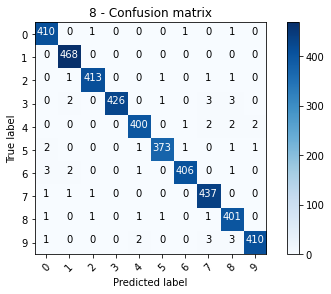

Iteration No. 9

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37376/37804 [============================>.] - ETA: 0s - loss: 4.8807 - acc: 0.9426
Epoch 00001: val_loss improved from inf to 6.74157, saving model to img_classifier_model_9_ResNet50_epoch10.h5
37804/37804 [==============================] - 25s 662us/sample - loss: 4.8736 - acc: 0.9430 - val_loss: 6.7416 - val_acc: 0.6568
Epoch 2/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.8279 - acc: 0.9913
Epoch 00002: val_loss improved from 6.74157 to 3.60967, saving model to img_classifier_model_9_ResNet50_epoch10.h5
37804/37804 [==============================] - 14s 373us/sample - loss: 3.8241 - acc: 0.9914 - val_loss: 3.6097 - val_acc: 0.9573
Epoch 3/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.2328 - acc: 0.9983
Epoch 00003: val_loss improved from 3.60967 to 3.05180, saving model to img_classifier_model_9_ResNet50_epoch10.h5
37804/37804 [==============================] - 1

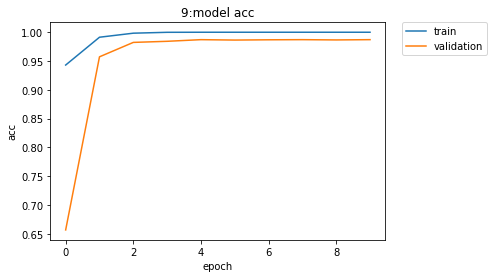

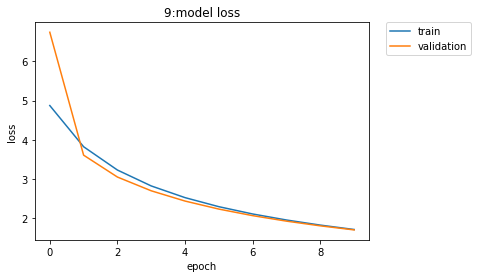

Done compiling best model.


9. Accuracy on validation data: 0.987131
Classification Report
              precision    recall  f1-score   support

           0    0.98086   0.99274   0.98676       413
           1    0.99359   0.99359   0.99359       468
           2    0.99038   0.98801   0.98920       417
           3    0.99768   0.98851   0.99307       435
           4    0.98526   0.98526   0.98526       407
           5    0.99472   0.99472   0.99472       379
           6    0.99512   0.98789   0.99149       413
           7    0.98853   0.97955   0.98402       440
           8    0.97337   0.99015   0.98168       406
           9    0.97129   0.97129   0.97129       418

   micro avg    0.98713   0.98713   0.98713      4196
   macro avg    0.98708   0.98717   0.98711      4196
weighted avg    0.98718   0.98713   0.98714      4196
 samples avg    0.98713   0.98713   0.98713      4196





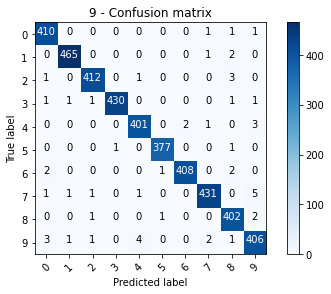

Iteration No. 10

Train on 37804 samples, validate on 4196 samples
Epoch 1/10
37376/37804 [============================>.] - ETA: 0s - loss: 4.8650 - acc: 0.9454
Epoch 00001: val_loss improved from inf to 17.73305, saving model to img_classifier_model_10_ResNet50_epoch10.h5
37804/37804 [==============================] - 23s 598us/sample - loss: 4.8581 - acc: 0.9457 - val_loss: 17.7330 - val_acc: 0.2960
Epoch 2/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.8062 - acc: 0.9925
Epoch 00002: val_loss improved from 17.73305 to 3.61253, saving model to img_classifier_model_10_ResNet50_epoch10.h5
37804/37804 [==============================] - 14s 371us/sample - loss: 3.8024 - acc: 0.9925 - val_loss: 3.6125 - val_acc: 0.9488
Epoch 3/10
37376/37804 [============================>.] - ETA: 0s - loss: 3.2069 - acc: 0.9986
Epoch 00003: val_loss improved from 3.61253 to 3.04823, saving model to img_classifier_model_10_ResNet50_epoch10.h5
37804/37804 [============================

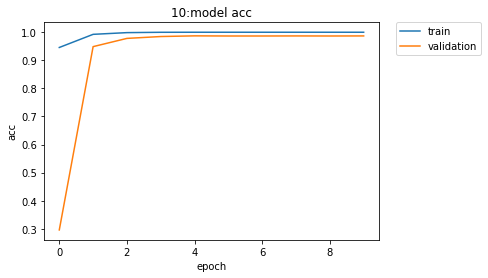

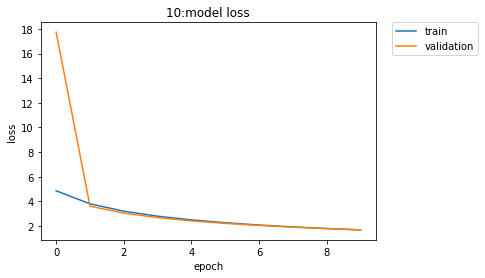

Done compiling best model.


10. Accuracy on validation data: 0.986892
Classification Report
              precision    recall  f1-score   support

           0    0.99274   0.99274   0.99274       413
           1    0.99143   0.98932   0.99037       468
           2    0.99043   0.99281   0.99162       417
           3    0.98611   0.97931   0.98270       435
           4    0.99005   0.97789   0.98393       407
           5    0.98684   0.98945   0.98814       379
           6    0.97857   0.99516   0.98679       413
           7    0.99083   0.98182   0.98630       440
           8    0.98519   0.98276   0.98397       406
           9    0.97636   0.98804   0.98216       418

   micro avg    0.98689   0.98689   0.98689      4196
   macro avg    0.98685   0.98693   0.98687      4196
weighted avg    0.98693   0.98689   0.98689      4196
 samples avg    0.98689   0.98689   0.98689      4196





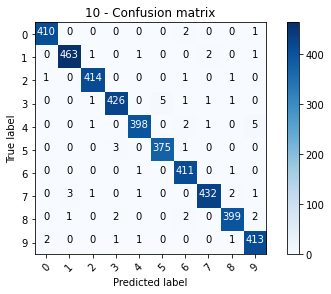

In [8]:
# ラベルの分布比率を維持した無作為抽出で10分割の交差検証を行う．シードは0で固定
skf = StratifiedKFold(n_splits=sp, shuffle = True, random_state = 0) 

for i, (train_idx, val_idx) in enumerate(skf.split(train, label_num)):
    # train(90%) / validation(10%) に分割
    X_train = train[train_idx]
    Y_train = label[train_idx]
    X_val = train[val_idx]
    Y_val = label[val_idx]
    
    # 分割ごとにモデルを初期化
    momentum = Adam(lr=learning_rate, decay=0.01)
    ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes) # ResNet-50
    ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

    # 学習を開始
    print("Iteration No. %d\n" %(i+1))
    
    # モデル読み込み時に使用するファイル
    model_file = 'img_classifier_model_%s_%s.h5' %(i+1, model_name)
    
    # 学習時に使用するコールバック
    def model_callbacks():
        # 各エポックでval_lossを監視し，最小値を更新した場合にモデルの重みを保存
        checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        # early_stopping_patience回連続でval_loss下がらなければ，学習打ち止め
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')

        return [checkpoint, early_stopping]

    callbacks_list = model_callbacks()
    
    # モデルのフィッティング
    history = ResNetModel.fit(X_train, 
                              Y_train, 
                              batch_size=batch_size, 
                              epochs=n_epoch,
                              verbose=1,
                              shuffle=True,
                              validation_data=(X_val, Y_val),
                              callbacks=callbacks_list)
    
    # 学習曲線の可視化
    def visualise_curve(model, monitor, itr):
        plt.figure()
        plt.plot(model.history[monitor])
        # validationも可視化する場合
        if isinstance(itr, int):
            plt.plot(model.history["val_"+ monitor])
        plt.title(str(itr)+":model "+ monitor)
        plt.ylabel(monitor)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.savefig(csv_dir+"/"+str(itr)+" - "+monitor+".png", bbox_inches="tight")
        plt.show()
            
    visualise_curve(history, "acc", i+1) # accuracyに関して表示
    visualise_curve(history, "loss", i+1) # lossに関して表示
    
    # 最良のモデルでvalidationデータの性能評価
    loaded_model = ResnetBuilder.build_resnet_50(inputShape, n_classes)
    loaded_model.load_weights(model_file)
    loaded_model.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])  
    plt.close("all")
    print("Done compiling best model.\n\n")
    
    # validationデータの予測
    predict[val_idx] = loaded_model.predict(X_val) # 各ラベルである確率
    predict_label[val_idx] = np_utils.to_categorical(np.argmax(predict[val_idx], axis=1), n_classes) # one-hot encoding
    
    # accuracyの表示
    print("%d. Accuracy on validation data: %f" %(i+1, accuracy_score(Y_val, predict_label[val_idx])))
    acc_str = str(i+1)+". Accuracy on validation data: "+ str(accuracy_score(Y_val, predict_label[val_idx]))+"\n\n"
    acc_list[i] = accuracy_score(Y_val, predict_label[val_idx])

    # その他の評価指標の表示と結果の保存
    print("Classification Report")
    report = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5)+"\n\n"
    report_file=open(csv_dir + "/report_" + model_name + ".txt","a")
    report_file.write(acc_str + report)
    report_file.close()
    print(report)
    other_score = classification_report(Y_val, predict_label[val_idx], target_names = class_names, digits = 5, output_dict=True)
    
    for j in range(n_classes):
        precision_list[i,j] = other_score[str(j)]["precision"]
        recall_list[i,j] = other_score[str(j)]["recall"]
        fscore_list[i,j] = other_score[str(j)]["f1-score"]
        
    avg_precision[i] = other_score["macro avg"]["precision"]
    avg_recall[i] = other_score["macro avg"]["recall"]
    avg_fscore[i] = other_score["macro avg"]["f1-score"]

    # 混合行列の計算
    np.set_printoptions(precision=2)
    cnf_matrix = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(predict[val_idx], axis=1))

    # 混合行列の描画と保存
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize: # パーセント表記にしたい場合
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            filename = title + "_normalized.png"
        else: # 実際のデータ数で表示したい場合
            filename = title + "_nonnorm.png"

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(conf_dir + "/" + filename, bbox_inches="tight")
        plt.show()

    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title=str(i+1)+" - Confusion matrix")
    
    # 各交差検証の終わりに不要なデータを破棄
    clear_session()
    del ResNetModel, loaded_model, history, X_train, X_val, Y_train, Y_val
    gc.collect()
    
#clear_output()

# move h5 file
#for i in glob.glob("*model*"+model_name+"*"+"h5"):
#    shutil.move(i, model_dir)

# モデルファイルの削除
for i in glob.glob("*"+model_name+"*"):
    os.remove(i)

### 4.2.2 Total Results Report

Accuracy on all validarion data: 0.986071
Classification Report
              precision    recall  f1-score   support

           0    0.98655   0.99395   0.99024      4132
           1    0.99337   0.99189   0.99263      4684
           2    0.98587   0.98564   0.98575      4177
           3    0.98800   0.98437   0.98618      4351
           4    0.98791   0.98330   0.98560      4072
           5    0.99121   0.98076   0.98596      3795
           6    0.98983   0.98816   0.98899      4137
           7    0.98526   0.98705   0.98615      4401
           8    0.97332   0.98769   0.98045      4063
           9    0.97894   0.97684   0.97789      4188

   micro avg    0.98607   0.98607   0.98607     42000
   macro avg    0.98603   0.98596   0.98599     42000
weighted avg    0.98610   0.98607   0.98607     42000
 samples avg    0.98607   0.98607   0.98607     42000





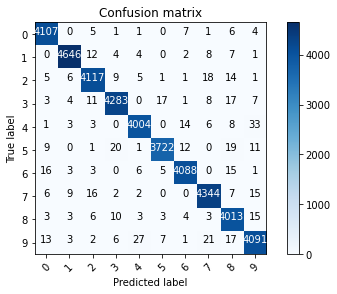

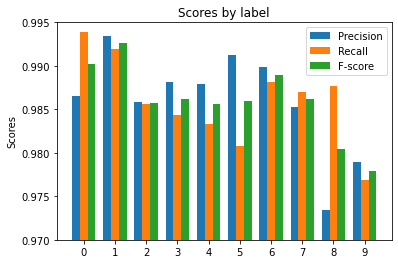

In [61]:
# 交差検証の結果の集計
plt.close('all')

# accuracyの表示
print('Accuracy on all validarion data: %f' %accuracy_score(label, predict_label))
acc_str = "Accuracy on all validarion data: "+ str(accuracy_score(label, predict_label))+"\n\n"

print('Classification Report')
report = classification_report(label, predict_label, target_names = class_names, digits = 5)+"\n\n"
report_file=open(csv_dir+"/report_"+ model_name + ".txt","a")
report_file.write(acc_str + report)
report_file.close()
print(report)

# 混合行列の計算
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(predict_label, axis=1))

# 混合行列の描画と保存
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

# 各交差検証の評価値を集計
score_table = pd.DataFrame(index = list(range(1,sp+1)))
score_table["Accuracy"] = acc_list
score_table["avg_Precision"] = avg_precision
score_table["avg_Recall"] = avg_recall
score_table["avg_F-score"] = avg_fscore

for i in range(n_classes):
    score_table[str(i) + "_Precision"] = precision_list[:, i]
    score_table[str(i) + "_Recall"] = recall_list[:, i]    
    score_table[str(i) + "_F-score"] = fscore_list[:, i]    
    
# 平均と標準偏差を計算して追加
avg = pd.Series(score_table.mean(),name="Avg")
std = pd.Series(score_table.std(),name="Std")

# 資料等に乗せるために整形したものも追加　(平均精度を % 表記，括弧内に標準偏差)
sr = []
for col in score_table.columns:
    sr.append(str(round(avg[col]*100,1))+"("+str(round(std[col]*100,1))+")%")
    
sr = pd.Series(sr, index=score_table.columns, name="sr")

# 追加データを結合
score_table = score_table.append(avg)
score_table = score_table.append(std)
score_table = score_table.append(sr)

# 結果ファイルを出力
score_table.to_csv(csv_dir+"/Result_"+model_name+".csv")

# 各ラベルの精度に関してグラフ化
x = np.arange(len(class_names)) * 2 # ラベルの位置
width = 0.5 # バーの横幅

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, avg[4:35:3], width, label="Precision")
rects2 = ax.bar(x, avg[5:35:3], width, label="Recall")
rects3 = ax.bar(x + width, avg[6:35:3], width, label="F-score")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by label')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylim(0.97,0.995)
ax.legend()

plt.savefig(csv_dir + "/" + "Score.png")
plt.show()

# 5. All data training and test

## 5.1 Training

Train on 42000 samples
Epoch 1/10
42000/42000 [==============================] - 27s 643us/sample - loss: 4.8027 - acc: 0.9483 - loss: 4.923
Epoch 2/10
42000/42000 [==============================] - 15s 348us/sample - loss: 3.7086 - acc: 0.9905
Epoch 3/10
42000/42000 [==============================] - 15s 349us/sample - loss: 3.1369 - acc: 0.9927
Epoch 4/10
42000/42000 [==============================] - 14s 331us/sample - loss: 2.7420 - acc: 0.9993
Epoch 5/10
42000/42000 [==============================] - 14s 333us/sample - loss: 2.4637 - acc: 0.9998
Epoch 6/10
42000/42000 [==============================] - 14s 332us/sample - loss: 2.2487 - acc: 0.9999
Epoch 7/10
42000/42000 [==============================] - 14s 332us/sample - loss: 2.0756 - acc: 1.0000
Epoch 8/10
42000/42000 [==============================] - 14s 334us/sample - loss: 1.9325 - acc: 1.0000
Epoch 9/10
42000/42000 [==============================] - 14s 334us/sample - loss: 1.8373 - acc: 0.9967
Epoch 10/10
42000/42000 [==

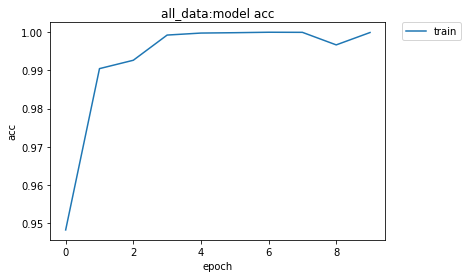

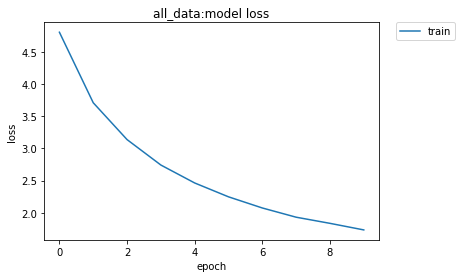

In [62]:
# モデルの初期化
momentum = Adam(lr=learning_rate, decay=0.01)
ResNetModel = ResnetBuilder.build_resnet_50(inputShape, n_classes)
ResNetModel.compile(optimizer=momentum, loss=losses.categorical_crossentropy, metrics=['acc'])

# モデルのフィッティング
history = ResNetModel.fit(train, label, batch_size=batch_size, epochs=n_epoch, verbose=1, shuffle=True)

# 学習曲線の可視化
visualise_curve(history, "acc", "all_data") # accuracyに関して表示
visualise_curve(history, "loss", "all_data") # lossに関して表示

## 5.2 Test

In [63]:
# testデータの予測
test_predict = ResNetModel.predict(test) # 各ラベルである確率
test_predict_label = np.argmax(test_predict, axis=1) # 予測ラベル（0-9）

# 予測結果をcsvに出力
result = pd.DataFrame({"ImageId" : list(range(1,len(test)+1)),
                       "Label" : test_predict_label})
result.to_csv(csv_dir + "/Test_Result.csv", index = False)